In [3]:
import matplotlib.pylab as plt
import cv2
import numpy as np
from matplotlib import image as image
from IPython.display import Image, display
import PIL.Image

In [4]:
def show_img(img):
    # plot masked frame
    plt.figure(figsize=(5,5))
    plt.imshow(img,cmap= "gray")
    plt.show()

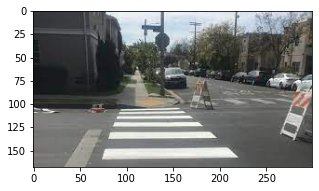

In [5]:
image = cv2.imread('crosswalk.jpeg', cv2.IMREAD_COLOR)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
show_img(image)
origin_height, origin_width, _ = image.shape

In [6]:
image_process = image.copy()


## Preprocessing

### downscale to 80x45

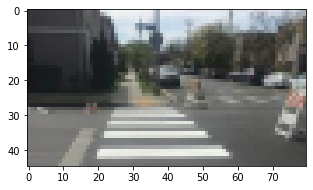

In [7]:
image_process = cv2.resize(image_process, (80,45), interpolation = cv2.INTER_AREA)
show_img(image_process)

### RBG to binary image

In [8]:
image_binary = np.zeros_like(image_process[:,:,0])
ret1, image_process = cv2.threshold(image_process,190,255,cv2.THRESH_BINARY)

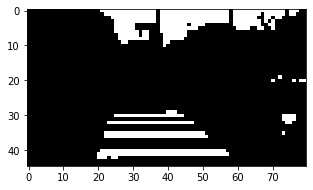

In [9]:
for ch in range(3):
    image_binary[image_process[:,:,ch]==255] = 255
# show_img(image_binary)
image_binary[(image_process[:,:,0]-image_process[:,:,1]) > 20] = 0
image_binary[(image_process[:,:,0]-image_process[:,:,2]) > 20] = 0
image_binary[(image_process[:,:,1]-image_process[:,:,2]) > 20] = 0
show_img(image_binary)

### morphology closing algorism

In [10]:
# def blockKernel(sizeX, sizeY = None):
#     if sizeY == None:
#         sizeY = sizeX
#     return np.ones((sizeX, sizeY), np.uint8)

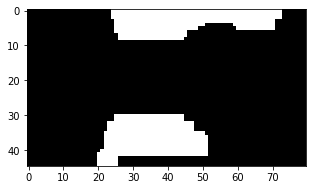

In [11]:
# two iteration of morphological closing operation is performed oon binary image accompanied by two
# iterations of opening operation. 
# Structuring element 3x3
# To exclude small white areas and fill larger white areas to form a consistent shape
# P. Soille, “Morphological Image Analysis: Principles and Applications”, pp. 105-135, Springer Science & Business Media, 2013.

image_morphology = cv2.morphologyEx(image_binary, cv2.MORPH_CLOSE, np.ones((3,3),np.uint8),iterations=2)
image_morphology = cv2.morphologyEx(image_morphology, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations =2)
image_morphology = cv2.morphologyEx(image_morphology, cv2.MORPH_CLOSE, np.ones((3,3),np.uint8),iterations=2)
image_ROI = cv2.morphologyEx(image_morphology, cv2.MORPH_OPEN, np.ones((3,3),np.uint8), iterations =2)

show_img(image_ROI)

### Get ROI

Object: 1 x1: 20 x2: 52 y1: 30 y2: 45
Object: 2 x1: 24 x2: 73 y1: 0 y2: 9


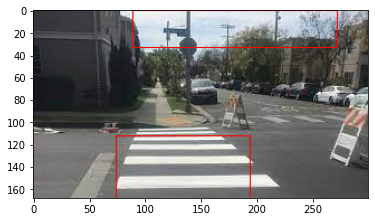

In [12]:
# Multiple rectangular ROI are possible to obtain in the previous step.
# All regions were further processes as potential crosswalk regions.

result = image_ROI.copy()
contours = cv2.findContours(image_ROI, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
colour = (255, 0, 0)
thickness = 1
i = 0

bboxs = []
for cntr in contours:
    x1,y1,w,h = cv2.boundingRect(cntr)
    x2 = x1+w
    y2 = y1+h
    
    # coorinates original images
    origin_x1 = int(x1 * origin_height / 45)
    origin_x2 = int(x2 * origin_height / 45)
    origin_y1 = int(y1 * origin_width / 80)
    origin_y2 = int(y2 * origin_width/ 80)
    bboxs.append([origin_x1,origin_y1,origin_x2,origin_y2])
    cv2.rectangle(image, (origin_x1, origin_y1), (origin_x2, origin_y2), colour, thickness)
    print("Object:", i+1, "x1:", x1, "x2:", x2, "y1:", y1, "y2:", y2)
    i += 1

plt.imshow(image)

## Do process if ROI exists

In [13]:
### convert color values to binary values

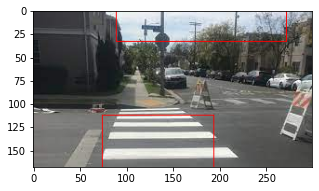

In [14]:
show_img(image)

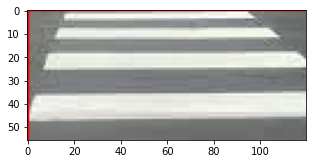

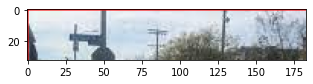

In [15]:
image_ROI = image.copy()
masks = []
import time
# t = time.time()
# mask = np.zeros(image_ROI.shape,np.uint8)    
for idx in range(len(bboxs)):
    masks.append(image_ROI[bboxs[idx][1]:bboxs[idx][3],bboxs[idx][0]:bboxs[idx][2]])
    show_img(masks[idx])
# print(time.time()-t)



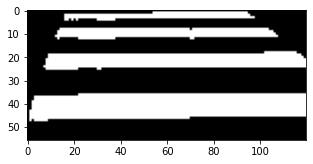

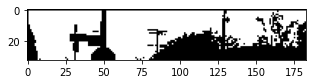

In [16]:
for idx in range(len(masks)):
    image_process = masks[idx].copy()
    image_binary2 = np.zeros_like(masks[idx][:,:,0])
    ret1, image_process = cv2.threshold(image_process,190,255,cv2.THRESH_BINARY)
    for ch in range(3):
        image_binary2[image_process[:,:,ch]==255] = 255
    # show_img(image_binary)
    image_binary2[(image_process[:,:,0]-image_process[:,:,1]) > 20] = 0
    image_binary2[(image_process[:,:,0]-image_process[:,:,2]) > 20] = 0
    image_binary2[(image_process[:,:,1]-image_process[:,:,2]) > 20] = 0
    show_img(image_binary2)

### morphological closing operation

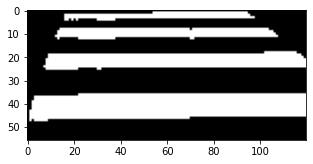

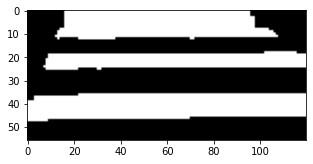

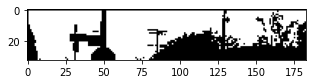

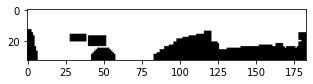

In [17]:
for idx in range(len(masks)):
    image_process = masks[idx].copy()
    image_binary2 = np.zeros_like(masks[idx][:,:,0])
    ret1, image_process = cv2.threshold(image_process,190,255,cv2.THRESH_BINARY)
    for ch in range(3):
        image_binary2[image_process[:,:,ch]==255] = 255
    # show_img(image_binary)
    image_binary2[(image_process[:,:,0]-image_process[:,:,1]) > 20] = 0
    image_binary2[(image_process[:,:,0]-image_process[:,:,2]) > 20] = 0
    image_binary2[(image_process[:,:,1]-image_process[:,:,2]) > 20] = 0
    show_img(image_binary2)
    # fills small balck gaps in the image to white
    # when talking about crosswalk region, such casres are caused by the washed out white paint or stains on
    # crosswalk stripes.
    image_morphology2 = cv2.morphologyEx(image_binary2, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8),iterations=1)
    show_img(image_morphology2)

### Detect specific points that represent crosswalk stripe edges.

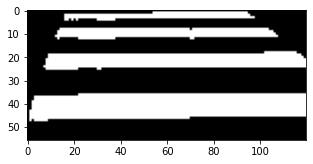

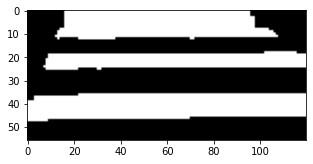

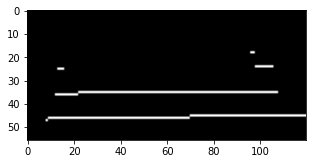

(56, 120)


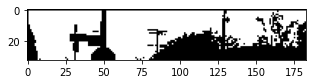

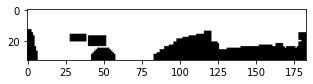

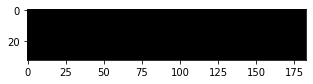

(33, 183)


In [21]:
edges_list = []
for idx in range(len(masks)):
    image_process = masks[idx].copy()
    image_binary2 = np.zeros_like(masks[idx][:,:,0])
    ret1, image_process = cv2.threshold(image_process,190,255,cv2.THRESH_BINARY)
    for ch in range(3):
        image_binary2[image_process[:,:,ch]==255] = 255
    # show_img(image_binary)
    image_binary2[(image_process[:,:,0]-image_process[:,:,1]) > 20] = 0
    image_binary2[(image_process[:,:,0]-image_process[:,:,2]) > 20] = 0
    image_binary2[(image_process[:,:,1]-image_process[:,:,2]) > 20] = 0
    show_img(image_binary2)
    # fills small balck gaps in the image to white
    # when talking about crosswalk region, such casres are caused by the washed out white paint or stains on
    # crosswalk stripes.
    image_morphology2 = cv2.morphologyEx(image_binary2, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8),iterations=1)
    show_img(image_morphology2)
    
    height, width = image_morphology2.shape
    edges = np.zeros_like(image_morphology2, dtype=np.uint8)
    for w_idx in range(width):
#         print(w_idx)
        # find blocks
        if image_morphology2[0,w_idx] == 0:
            # first pixel is black
            flag = 'black'
            start_black = 0
        else:
            # fist pixel is white
            flag = 'white'
            start_white = 0
        w1_black = 0
        w1_white = 0
        for h_idx in range(1,height):
            if image_morphology2[h_idx,w_idx] == 255 and flag == 'black':
                end_black = h_idx-1
                if w1_black == 0:
                    w1_black = end_black - start_black + 1
                else: # step 2
                    w2_black = end_black - start_black
                    if (w2_black > 1.2 * w1_black) and (w2_black < 2.1*w1_black):
                        edges[h_idx-1, w_idx] = 255
                    w1_black = w2_black
                start_white = h_idx
                flag = 'white'

            if image_morphology2[h_idx,w_idx] == 0 and flag == 'white':
                end_white = h_idx-1
                if  w1_white == 0:
                    w1_white = end_white - start_white + 1
                else:
                    w2_white = end_white - start_white
                    if (w2_white > 1.2 * w1_white) and (w2_white < 2.1*w1_white):
                        edges[h_idx-1, w_idx] = 255
                    w1_white = w2_white
                start_black = h_idx
                flag = 'black'                
    
    show_img(edges)
    print(edges.shape)        
    #     edges = cv2.Canny(image_morphology2,30,80)
    #     show_img(edges)

    edges_list.append(edges)
    
    

## line energy

In [22]:
edges.shape
print(edges_list[0].shape)
print(edges_list[1].shape)

(56, 120)
(33, 183)


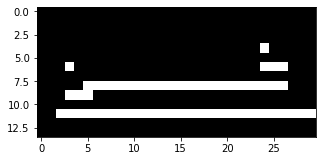

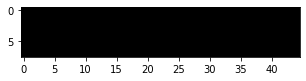

In [25]:
resolution_list = []
resolution_ratio = 4

for edges in edges_list:
    resolution_edges = cv2.resize(edges,
                              (edges.shape[1]//resolution_ratio,edges.shape[0]//resolution_ratio),
                              interpolation = cv2.INTER_AREA ) 
    resolution_edges[resolution_edges>0] = 255

#     resolution_edges = np.zeros((edges.shape[0]//resolution_ratio+1,
#                                 edges.shape[1]//resolution_ratio+1))
#     print(resolution_edges.shape)
#     for h_idx in range(0, edges.shape[0], resolution_ratio):
#         for w_idx in range(0, edges.shape[1], resolution_ratio):
#             resolution_edges[h_idx//4][w_idx//4] = edges[h_idx][w_idx]
    
    show_img(resolution_edges)
    resolution_list.append(resolution_edges)

In [26]:
def is_in_box(pic, h, w):
    if 0<=h and h<pic.shape[0] and 0<=w and w<pic.shape[1]:
        return True
    else:
        return False

for edges in resolution_list:
    #print(edges.shape)
    visited = np.zeros_like(edges)
    #print(visited.shape)
    
    total_sum = 0
    n = 0 # number of group
    
    for w_idx in range(edges.shape[1]):
        for h_idx in range(edges.shape[0]):
            if edges[h_idx, w_idx] == 255 and visited[h_idx, w_idx] == 0:
                visited[h_idx, w_idx] = 1
                cur_h = h_idx
                cur_w = w_idx
                sum = 0
                A = B = C = D = 0
                n += 1
                flag = True

                #print("start : ", n, cur_h, cur_w)
                
                while flag:
                    # print("helloe?")
                    # loop escpae
                    # print("n : ", n)
#                     print(n, cur_h, cur_w)
                    is_A = False
                    is_B = False
                    is_C = False
                    is_D = False
                    
                    if is_in_box(edges, cur_h, cur_w) == False:
                        print("e")
                        break
                    if is_in_box(edges, cur_h-1, cur_w+1) == False:
                        print("a")
                        break
                    if is_in_box(edges, cur_h, cur_w+1) == False:
                        print("b")
                        break
                    if is_in_box(edges, cur_h+1, cur_w+1) == False:
                        print("c")
#                         break
                        
                    if cur_w+1<edges.shape[1] and \
                        ((cur_h-1 >= 0 and edges[cur_h-1, cur_w+1] == 0) or cur_h-1<0) and \
                        edges[cur_h, cur_w+1] == 0 and \
                        ((cur_h+1 < edges.shape[0] and edges[cur_h+1, cur_w+1] == 0) or cur_h+1 >= edges.shape[0]):
                        flag = False
#                         print("herre")
                        break
                        
                    # calculate Sum of each group
#                     print("test : ", edges[cur_h, cur_w+1])
                    if is_in_box(edges, cur_h-1, cur_w+1) and edges[cur_h-1, cur_w+1] == 255 and visited[cur_h-1, cur_w+1] == 0:
                        visited[cur_h-1, cur_w+1] = 1
#                         print("A : ", A)
                        sum += A
                        A += 1
                        is_A = True
                        
                    if is_in_box(edges, cur_h, cur_w+1) and edges[cur_h, cur_w+1] == 255 and visited[cur_h, cur_w+1] == 0:
                        visited[cur_h, cur_w+1] = 1
                        sum += B
#                         print("B : ", B)
                        B += 1
                        is_B = True
                        
                    if is_in_box(edges, cur_h+1, cur_w+1) and edges[cur_h+1, cur_w+1] == 255 and visited[cur_h+1, cur_w+1] == 0:
                        visited[cur_h+1, cur_w+1] = 1
                        sum += C
#                         print("C : ", C)
                        C += 1
                        is_C = True
                    
                    if is_in_box(edges, cur_h+1, cur_w) and edges[cur_h+1, cur_w] == 255 and visited[cur_h+1, cur_w] == 0:
                        visited[cur_h+1, cur_w] = 1
                        sum += D
#                         print("D : ", D)
                        D+= 1
                        is_D = True
                        
                    # update cur_h, cur_w
                    if is_B:
                        if is_A:
                            if is_in_box(edges, cur_h-2, cur_w+2) and edges[cur_h-2, cur_w+2] == 255:
                                cur_h -= 1
                                cur_w += 1
                            else:
                                cur_w += 1
                        elif is_C:
                            if is_in_box(edges, cur_h+2, cur_w+2) and edges[cur_h+2, cur_w+2] == 255:
                                cur_h += 1
                                cur_w += 1
                            else:
                                cur_w += 1
                        else:
                            cur_w += 1
                    elif is_A:
                        cur_h -= 1
                        cur_w += 1
                    elif is_C:
                        cur_h += 1
                        cur_w += 1
                        
#                 print("sum : ", sum)        
                total_sum += sum
    print("total sum : ", total_sum)
    print("n : ", n)

a
total sum :  584
n :  5
total sum :  0
n :  0
